########## INICIO FASE 7 ##############

Librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pulp
import os

Configuraciones


In [2]:
plt.style.use('default')
sns.set_palette("Set2")
BASE_DIR = os.path.dirname(os.getcwd())

In [3]:
print("=== ANÁLISIS DE SENSIBILIDAD Y COMPARACIÓN ===")
print(f"Ejecutado: {datetime.now()}")

=== ANÁLISIS DE SENSIBILIDAD Y COMPARACIÓN ===
Ejecutado: 2025-09-06 21:49:25.979741


FUNCION PARA MEJORAR NOMBRE DE COLUMNAS

In [4]:
def obtener_nombre_columna(df, nombres_posibles):
    """Obtener el nombre correcto de la columna"""
    for nombre in nombres_posibles:
        if nombre in df.columns:
            return nombre
    return None

CARGANDO DATOS EXISTENTES

CARGA DE DATOS

In [5]:
results_path = os.path.join(BASE_DIR, "results", "assignment_results.csv")
schedule_path = os.path.join(BASE_DIR, "results", "schedule_detailed.csv")

asignaciones_base = pd.read_csv(results_path)
schedule_base = pd.read_csv(schedule_path) if os.path.exists(schedule_path) else None

OBTENER NOMBRES DE COLUMNAS CORRECTOS

In [6]:
col_tecnico_asign = obtener_nombre_columna(asignaciones_base, ['Id_tecnico', 'id_tecnico', 'tecnico_id'])
col_job_asign = obtener_nombre_columna(asignaciones_base, ['job_id', 'id_job'])

print(f"Asignaciones base: {len(asignaciones_base)} trabajos")
print(f"Columna técnico: {col_tecnico_asign}")
print(f"Columna job: {col_job_asign}")

if schedule_base is not None:
    print(f"Horario base: {len(schedule_base)} trabajos planificados")

Asignaciones base: 30 trabajos
Columna técnico: id_tecnico
Columna job: job_id
Horario base: 30 trabajos planificados


ANALISIS DE SENSIBILIDAD

In [7]:
def analizar_sensibilidad_duraciones(variacion_percent):
    """Analizar sensibilidad a cambios en duraciones"""
    print(f"\n🔍 SENSIBILIDAD: Duraciones ±{variacion_percent}%")
    
    # Cargar datos originales
    jobs = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "jobs_clean.csv"))
    tecnicos = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "tecnicos_clean.csv"))
    
    # Obtener nombres de columnas
    col_tecnico_tec = obtener_nombre_columna(tecnicos, ['Id_tecnico', 'id_tecnico', 'tecnico_id'])
    
    # Aplicar variación
    jobs_mod = jobs.copy()
    factor = 1 + (variacion_percent / 100) * np.random.choice([1, -1], size=len(jobs))
    jobs_mod['duracion_horas'] = jobs_mod['duracion_horas'] * factor
    
    # Calcular nueva demanda
    demanda_original = jobs['duracion_horas'].sum()
    demanda_mod = jobs_mod['duracion_horas'].sum()
    capacidad_total = tecnicos['capacidad_diaria_h'].sum() * 7
    
    resultado = {
        'variacion': variacion_percent,
        'demanda_original': demanda_original,
        'demanda_modificada': demanda_mod,
        'capacidad_total': capacidad_total,
        'diferencia_absoluta': abs(demanda_mod - demanda_original),
        'diferencia_porcentual': ((demanda_mod - demanda_original) / demanda_original) * 100,
        'utilizacion_original': (demanda_original / capacidad_total) * 100,
        'utilizacion_modificada': (demanda_mod / capacidad_total) * 100
    }
    
    print(f"   Demanda original: {demanda_original:.1f}h")
    print(f"   Demanda modificada: {demanda_mod:.1f}h")
    print(f"   Diferencia: {resultado['diferencia_porcentual']:+.1f}%")
    print(f"   Utilización: {resultado['utilizacion_original']:.1f}% → {resultado['utilizacion_modificada']:.1f}%")
    
    return resultado


Probar diferentes variaciones

In [8]:
variaciones = [-20, -10, 0, 10, 20]
resultados_sensibilidad = []

for variacion in variaciones:
    resultado = analizar_sensibilidad_duraciones(variacion)
    resultados_sensibilidad.append(resultado)


🔍 SENSIBILIDAD: Duraciones ±-20%
   Demanda original: 92.0h
   Demanda modificada: 98.8h
   Diferencia: +7.4%
   Utilización: 24.3% → 26.1%

🔍 SENSIBILIDAD: Duraciones ±-10%
   Demanda original: 92.0h
   Demanda modificada: 95.0h
   Diferencia: +3.3%
   Utilización: 24.3% → 25.1%

🔍 SENSIBILIDAD: Duraciones ±0%
   Demanda original: 92.0h
   Demanda modificada: 92.0h
   Diferencia: +0.0%
   Utilización: 24.3% → 24.3%

🔍 SENSIBILIDAD: Duraciones ±10%
   Demanda original: 92.0h
   Demanda modificada: 90.6h
   Diferencia: -1.5%
   Utilización: 24.3% → 24.0%

🔍 SENSIBILIDAD: Duraciones ±20%
   Demanda original: 92.0h
   Demanda modificada: 89.6h
   Diferencia: -2.6%
   Utilización: 24.3% → 23.7%


Crear DataFrame de resultados

In [9]:
df_sensibilidad = pd.DataFrame(resultados_sensibilidad)
df_sensibilidad.to_csv(os.path.join(BASE_DIR, "results", "sensibilidad_duraciones.csv"), index=False)

3. Escenario: Ausencia de Técnico

In [10]:
def simular_ausencia_tecnico(tecnico_ausente):
    """Simular ausencia de un técnico"""
    print(f"\n🔍 ESCENARIO: Ausencia de técnico {tecnico_ausente}")
    
    # Cargar datos
    jobs = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "jobs_clean.csv"))
    tecnicos = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "tecnicos_clean.csv"))
    
    # Obtener nombres de columnas
    col_tecnico_tec = obtener_nombre_columna(tecnicos, ['Id_tecnico', 'id_tecnico', 'tecnico_id'])
    col_tecnico_asign = obtener_nombre_columna(asignaciones_base, ['Id_tecnico', 'id_tecnico', 'tecnico_id'])
    
    # Filtrar técnicos disponibles
    tecnicos_disponibles = tecnicos[tecnicos[col_tecnico_tec] != tecnico_ausente]
    
    # Encontrar trabajos asignados al técnico ausente
    jobs_afectados = asignaciones_base[asignaciones_base[col_tecnico_asign] == tecnico_ausente]
    
    # Calcular impacto
    capacidad_perdida = tecnicos[tecnicos[col_tecnico_tec] == tecnico_ausente]['capacidad_diaria_h'].values[0] * 7
    horas_afectadas = jobs_afectados['duracion_horas'].sum() if 'duracion_horas' in jobs_afectados.columns else 0
    
    resultado = {
        'tecnico_ausente': tecnico_ausente,
        'capacidad_perdida_h': capacidad_perdida,
        'trabajos_afectados': len(jobs_afectados),
        'horas_afectadas': horas_afectadas,
        'tecnicos_disponibles': len(tecnicos_disponibles),
        'capacidad_restante': tecnicos_disponibles['capacidad_diaria_h'].sum() * 7
    }
    
    print(f"   Trabajos afectados: {resultado['trabajos_afectados']}")
    print(f"   Horas afectadas: {resultado['horas_afectadas']:.1f}h")
    print(f"   Capacidad perdida: {resultado['capacidad_perdida_h']:.1f}h")
    print(f"   Capacidad restante: {resultado['capacidad_restante']:.1f}h")
    
    return resultado

Probar ausencia de cada técnico

In [11]:
tecnicos_lista = ['T1', 'T2', 'T3', 'T4', 'T5']
resultados_ausencia = []

for tech in tecnicos_lista:
    resultado = simular_ausencia_tecnico(tech)
    resultados_ausencia.append(resultado)

df_ausencia = pd.DataFrame(resultados_ausencia)
df_ausencia.to_csv(os.path.join(BASE_DIR, "results", "sensibilidad_ausencias.csv"), index=False)


🔍 ESCENARIO: Ausencia de técnico T1
   Trabajos afectados: 5
   Horas afectadas: 16.0h
   Capacidad perdida: 56.0h
   Capacidad restante: 322.0h

🔍 ESCENARIO: Ausencia de técnico T2
   Trabajos afectados: 4
   Horas afectadas: 15.0h
   Capacidad perdida: 49.0h
   Capacidad restante: 329.0h

🔍 ESCENARIO: Ausencia de técnico T3
   Trabajos afectados: 6
   Horas afectadas: 15.0h
   Capacidad perdida: 56.0h
   Capacidad restante: 322.0h

🔍 ESCENARIO: Ausencia de técnico T4
   Trabajos afectados: 3
   Horas afectadas: 15.0h
   Capacidad perdida: 56.0h
   Capacidad restante: 322.0h

🔍 ESCENARIO: Ausencia de técnico T5
   Trabajos afectados: 8
   Horas afectadas: 16.0h
   Capacidad perdida: 56.0h
   Capacidad restante: 322.0h


4. Comparación con Métodos Baseline

In [12]:
def asignacion_aleatoria(jobs, tecnicos, habilidades):
    """Asignación aleatoria respetando habilidades"""
    asignaciones = []
    
    # Obtener nombres de columnas
    col_tecnico_hab = obtener_nombre_columna(habilidades, ['id_tecnico', 'Id_tecnico', 'tecnico_id'])
    col_job_hab = obtener_nombre_columna(habilidades, ['id_job', 'job_id'])
    
    for _, job in jobs.iterrows():
        job_id = job['id_job']
        
        # Encontrar técnicos compatibles
        techs_compatibles = habilidades[(habilidades[col_job_hab] == job_id) & 
                                      (habilidades['compatible'] == 1)][col_tecnico_hab].tolist()
        
        if techs_compatibles:
            # Asignar aleatoriamente
            tecnico_asignado = np.random.choice(techs_compatibles)
            asignaciones.append({
                'job_id': job_id,
                'tecnico_id': tecnico_asignado,
                'duracion_horas': job['duracion_horas']
            })
    
    return pd.DataFrame(asignaciones)

In [13]:
def asignacion_greedy(jobs, tecnicos, habilidades):
    """Asignación greedy por prioridad"""
    # Obtener nombres de columnas
    col_tecnico_tec = obtener_nombre_columna(tecnicos, ['Id_tecnico', 'id_tecnico', 'tecnico_id'])
    col_tecnico_hab = obtener_nombre_columna(habilidades, ['id_tecnico', 'Id_tecnico', 'tecnico_id'])
    col_job_hab = obtener_nombre_columna(habilidades, ['id_job', 'job_id'])
    
    # Ordenar jobs por duración (más largos primero)
    jobs_ordenados = jobs.sort_values('duracion_horas', ascending=False)
    
    asignaciones = []
    carga_tecnicos = {tech: 0 for tech in tecnicos[col_tecnico_tec]}
    
    for _, job in jobs_ordenados.iterrows():
        job_id = job['id_job']
        
        # Encontrar técnicos compatibles
        techs_compatibles = habilidades[(habilidades[col_job_hab] == job_id) & 
                                      (habilidades['compatible'] == 1)][col_tecnico_hab].tolist()
        
        if techs_compatibles:
            # Asignar al técnico con menor carga
            techs_con_carga = [(tech, carga_tecnicos[tech]) for tech in techs_compatibles]
            techs_con_carga.sort(key=lambda x: x[1])
            
            tecnico_asignado = techs_con_carga[0][0]
            carga_tecnicos[tecnico_asignado] += job['duracion_horas']
            
            asignaciones.append({
                'job_id': job_id,
                'tecnico_id': tecnico_asignado,
                'duracion_horas': job['duracion_horas']
            })
    
    return pd.DataFrame(asignaciones), carga_tecnicos

CARGA DE DATOS POR COMPARACION

In [14]:
jobs = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "jobs_clean.csv"))
tecnicos = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "tecnicos_clean.csv"))
habilidades = pd.read_csv(os.path.join(BASE_DIR, "data", "clean", "habilidades_clean.csv"))

print("\n🔍 COMPARACIÓN CON MÉTODOS BASELINE")


🔍 COMPARACIÓN CON MÉTODOS BASELINE


OBTENER NOMBRES DE COLUMNAS PARA ASIGNACIONES BASE

In [15]:
col_tecnico_asign = obtener_nombre_columna(asignaciones_base, ['Id_tecnico', 'id_tecnico', 'tecnico_id'])

METODO ALEATORIO

In [16]:
print("1. Asignación Aleatoria:")
df_aleatorio = asignacion_aleatoria(jobs, tecnicos, habilidades)
carga_max_aleatoria = df_aleatorio.groupby('tecnico_id')['duracion_horas'].sum().max()
print(f"   Carga máxima: {carga_max_aleatoria:.1f}h")
print(f"   Trabajos asignados: {len(df_aleatorio)}/{len(jobs)}")

1. Asignación Aleatoria:
   Carga máxima: 33.0h
   Trabajos asignados: 30/30


Método greedy

In [17]:
print("2. Asignación Greedy:")
df_greedy, cargas_greedy = asignacion_greedy(jobs, tecnicos, habilidades)
carga_max_greedy = max(cargas_greedy.values()) if cargas_greedy else 0
print(f"   Carga máxima: {carga_max_greedy:.1f}h")
print(f"   Trabajos asignados: {len(df_greedy)}/{len(jobs)}")

2. Asignación Greedy:
   Carga máxima: 26.0h
   Trabajos asignados: 30/30


Nuestro método óptimo

In [18]:
print("3. Nuestro Método (Óptimo):")
if col_tecnico_asign and col_tecnico_asign in asignaciones_base.columns:
    carga_max_optima = asignaciones_base.groupby(col_tecnico_asign)['duracion_horas'].sum().max()
else:
    carga_max_optima = 0

print(f"   Carga máxima: {carga_max_optima:.1f}h")
print(f"   Trabajos asignados: {len(asignaciones_base)}/{len(jobs)}")


3. Nuestro Método (Óptimo):
   Carga máxima: 16.0h
   Trabajos asignados: 30/30


GUARDA DE COMPARACIONES

In [19]:
comparacion = {
    'metodo': ['Aleatorio', 'Greedy', 'Óptimo'],
    'carga_maxima': [carga_max_aleatoria, carga_max_greedy, carga_max_optima],
    'trabajos_asignados': [len(df_aleatorio), len(df_greedy), len(asignaciones_base)],
    'completitud': [len(df_aleatorio)/len(jobs), len(df_greedy)/len(jobs), len(asignaciones_base)/len(jobs)]
}

df_comparacion = pd.DataFrame(comparacion)
df_comparacion.to_csv(os.path.join(BASE_DIR, "results", "comparacion_metodos.csv"), index=False)

5. Visualizaciones GRAFICOS DE COMPARACIONES DE METODOS

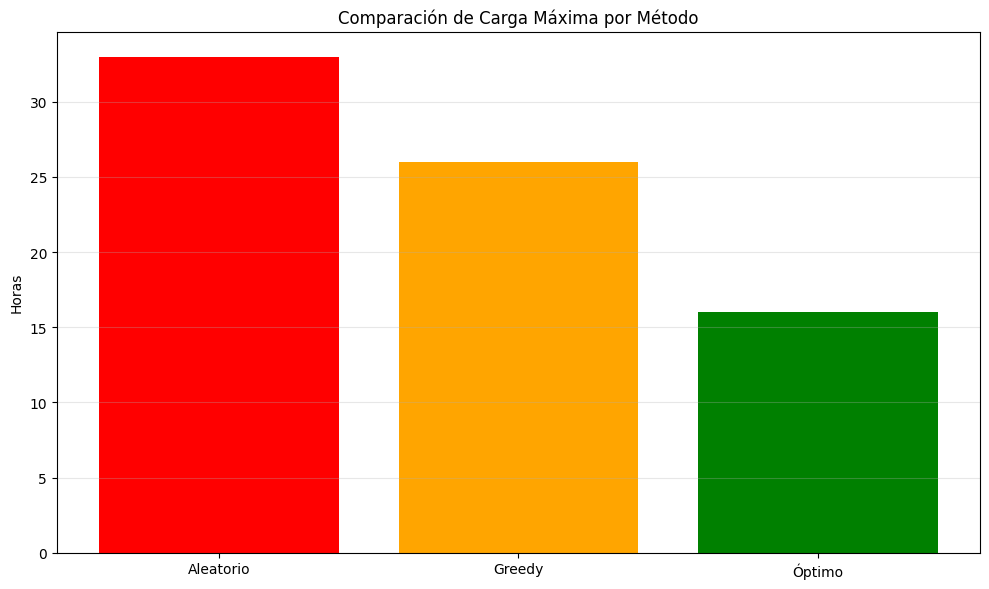

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(df_comparacion['metodo'], df_comparacion['carga_maxima'], color=['red', 'orange', 'green'])
plt.title('Comparación de Carga Máxima por Método')
plt.ylabel('Horas')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "results", "comparacion_carga_maxima.png"), dpi=300, bbox_inches='tight')
plt.show()

GRAFICOS DE SENSIBILIDAD

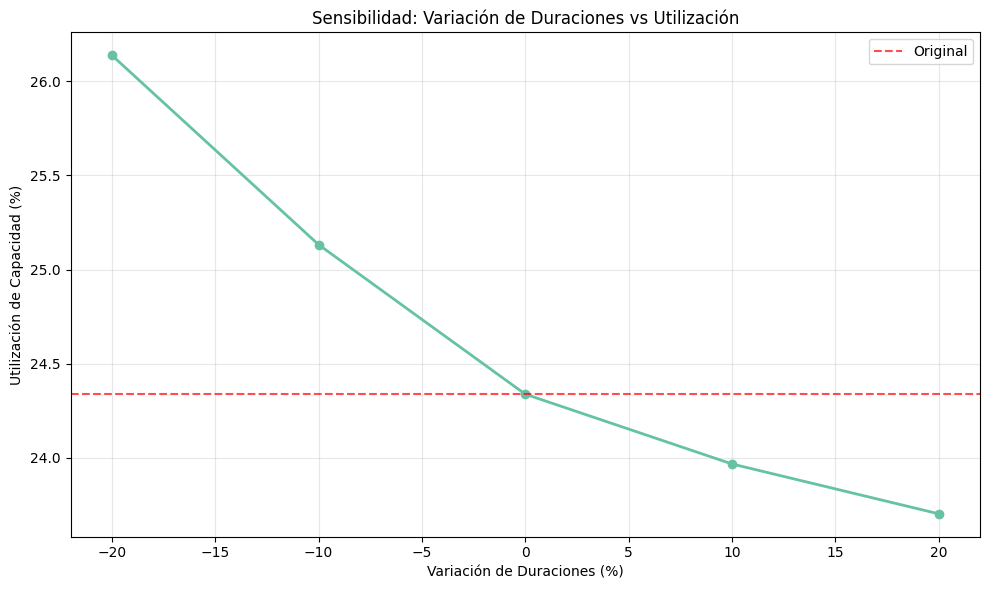

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df_sensibilidad['variacion'], df_sensibilidad['utilizacion_modificada'], 'o-', linewidth=2)
plt.axhline(y=df_sensibilidad['utilizacion_original'].iloc[2], color='r', linestyle='--', alpha=0.7, label='Original')
plt.title('Sensibilidad: Variación de Duraciones vs Utilización')
plt.xlabel('Variación de Duraciones (%)')
plt.ylabel('Utilización de Capacidad (%)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "results", "sensibilidad_utilizacion.png"), dpi=300, bbox_inches='tight')
plt.show()

Gráfico de impacto por ausencia

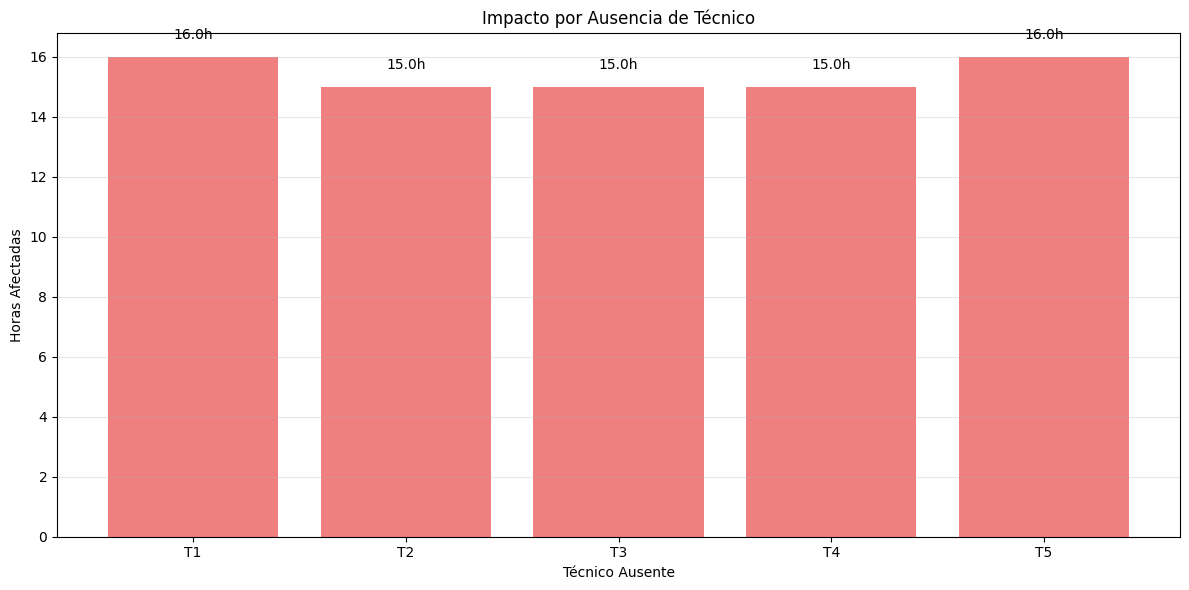

In [22]:
plt.figure(figsize=(12, 6))
bars = plt.bar(df_ausencia['tecnico_ausente'], df_ausencia['horas_afectadas'], color='lightcoral')
plt.title('Impacto por Ausencia de Técnico')
plt.xlabel('Técnico Ausente')
plt.ylabel('Horas Afectadas')
plt.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar, horas in zip(bars, df_ausencia['horas_afectadas']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{horas:.1f}h', 
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "results", "impacto_ausencias.png"), dpi=300, bbox_inches='tight')
plt.show()

RESUMEN EJECUTIVO

In [23]:
print("\n" + "="*60)
print(" RESUMEN EJECUTIVO - ANÁLISIS DE SENSIBILIDAD")
print("="*60)

print(f"\n SENSIBILIDAD A DURACIONES:")
if len(df_sensibilidad) >= 5:
    variacion_utilizacion = abs(df_sensibilidad['utilizacion_modificada'].iloc[0] - df_sensibilidad['utilizacion_modificada'].iloc[4])
    print(f"   Variación ±20% afecta utilización en ±{variacion_utilizacion:.1f}%")

print(f"\n RIESGO POR AUSENCIAS:")
if not df_ausencia.empty:
    tecnico_max_impacto = df_ausencia.loc[df_ausencia['horas_afectadas'].idxmax()]
    print(f"   Técnico con mayor impacto: {tecnico_max_impacto['tecnico_ausente']} ({tecnico_max_impacto['horas_afectadas']:.1f}h)")

print(f"\n COMPARACIÓN DE MÉTODOS:")
if not df_comparacion.empty:
    mejor_metodo = df_comparacion.loc[df_comparacion['carga_maxima'].idxmin()]
    print(f"   Mejor método: {mejor_metodo['metodo']} ({mejor_metodo['carga_maxima']:.1f}h)")
    if carga_max_aleatoria > 0:
        mejora = ((carga_max_aleatoria - mejor_metodo['carga_maxima']) / carga_max_aleatoria * 100)
        print(f"   Mejora vs aleatorio: {mejora:.1f}%")

print(f"\n RECOMENDACIONES:")
print("   1. Mantener buffer del 10-15% para variaciones en duraciones")
print("   2. Implementar cross-training para reducir dependencia de técnicos clave")
print("   3. Usar método óptimo para asignaciones regulares")

print("\n Análisis completado. Resultados guardados en /results/")


 RESUMEN EJECUTIVO - ANÁLISIS DE SENSIBILIDAD

 SENSIBILIDAD A DURACIONES:
   Variación ±20% afecta utilización en ±2.4%

 RIESGO POR AUSENCIAS:
   Técnico con mayor impacto: T1 (16.0h)

 COMPARACIÓN DE MÉTODOS:
   Mejor método: Óptimo (16.0h)
   Mejora vs aleatorio: 51.5%

 RECOMENDACIONES:
   1. Mantener buffer del 10-15% para variaciones en duraciones
   2. Implementar cross-training para reducir dependencia de técnicos clave
   3. Usar método óptimo para asignaciones regulares

 Análisis completado. Resultados guardados en /results/
